In [148]:
import requests
import json
import xmltodict
import urllib.parse
import opencitingpy
import datetime
import sqlite3
import os
from matplotlib import pyplot as plt
import numpy as np
import re
import math
import ipywidgets as widgets
from IPython.display import display, clear_output
import re 

import xml.etree.ElementTree as ET
from collections import Counter

In [149]:
# Anlegen von Datenbankspeicherort, falls er nicht existiert
path = "C:\MA_Pethke_3992454"
if not os.path.exists(path):
    os.makedirs(path)

# Verbindung zu DB aufbauen, DB wird automatisch erstellt, wenn keine da ist
con = sqlite3.connect("C:\MA_Pethke_3992454\MA_3992454_idea_2.db")
cur = con.cursor()

In [150]:
## Tabellen Schema erstellen
#------------------- Tabelle Dokument --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Dokumente(PMID INTEGER UNIQUE, titel TEXT, pubyear YEAR)")

#------------------- Tabelle Zitationen --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Zitationen(PMID INTEGER, Jahr YEAR, Anzahl INETEGER, UNIQUE(PMID,Jahr) ON CONFLICT REPLACE)")

#------------------- Tabelle Mesh --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Mesh(UI VARCHAR UNIQUE, name TEXT, jahr YEAR, emergent INTEGER, nichtEmergent INTEGER, nichtEmergentKorrigiert INTEGER)")

#------------------- Tabelle Mesh - PMID --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS Mesh_PMID(UI VARCHAR, PMID INTEGER, UNIQUE(UI,PMID) ON CONFLICT REPLACE)")


#------------------- Tabelle Dokument-Mesh-Analyse --------------------------------------#
cur.execute("CREATE TABLE IF NOT EXISTS MeshDokumentAnalyse(PMID INTEGER, UI VARCHAR, emergent INTEGER, nichtEmergent INTEGER, nichtEmergentKorrigiert INTEGER, UNIQUE(PMID,UI) ON CONFLICT REPLACE)")
con.commit()

In [151]:
##  INSERT DB

def insertMeshData_db(meshUI_loc, meshTerm_loc, meshDate_loc):
    print("Das ausgewählte MeSH " + str(meshUI_loc) + " wird in die DB eingepflegt")
    try:
        cur.execute("INSERT INTO Mesh (UI, name, jahr) VALUES (\""+str(meshUI_loc)+"\", \""+str(meshTerm_loc)+"\", \""+str(meshDate_loc)+"\")")
        con.commit()
        # Insert erfolgreich
    except:
        print("fail - wurde schon eingefügt")
        return
        # MeSH schon in DB

def insertCitations_db(pmid_loc, histo):
    # print("Für das Dokument " + str(pmid_loc) + " werden die Zitationsdaten in die Datenbank eingepflegt")
    for year in histo:
        try:
            cur.execute("INSERT INTO Zitationen (PMID, Jahr, Anzahl) VALUES (\""+str(pmid_loc)+"\", \""+str(year)+"\", \""+str(histo[year])+"\")")
            con.commit()
            # Insert erfolgreich
        except:
            print("fail")
            return
            # MeSH schon in DB

def insertAnalyseOutputPMIDMesh(pmid, ui, pmidE, pmidNE, pmidNEK):
    try:
        cur.execute("INSERT INTO MeshDokumentAnalyse(PMID, UI, emergent, nichtEmergent, nichtEmergentKorrigiert) VALUES ('"+str(pmid)+"', '"+str(ui)+"', '"+str(pmidE)+"', '"+str(pmidNE)+"', '"+str(pmidNEK)+"')")
        con.commit()
        # Insert erfolgreich
    except:
        print("fail - wurde schon eingefügt")
        return

def insertAnalyseOutputMesh(ui, uiE, uiNE, uiNEK):
    try:
        cur.execute("UPDATE Mesh SET emergent = '"+str(uiE)+"', nichtEmergent = '" + str(uiNE) + "', nichtEmergentKorrigiert = '"+str(uiNEK)+"' WHERE UI = '" + str(ui) + "'")
        con.commit()
        # Insert erfolgreich
    except:
        # print("fail - wurde schon eingefügt")
        return

In [152]:
## USEFUL

def getPMIDsWithMeSH(meshTerm_loc, meshYear_loc):
    limit = 50 # API limited to first 10000 documents; esearch is a way to get all data, but u have to work on an unix environment https://dataguide.nlm.nih.gov/edirect/edirect-vs-e-utilities.html
    # Abfrage von Dokumente, die vor der Aufnahme des MeSHs veröffentlicht wurden (Von 1900 an)
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=("+urllib.parse.quote(meshTerm_loc)+"[MeSH+Terms])+AND+((\"1900\"[Date+-+Publication]+%3A+\""+str(meshYear_loc)+"\"[Date+-+Publication]))&retmax="+str(limit)+"&sort=relevance&retmode=json"
    # print(url)
    requ = requests.get(url)
    requ_json = json.loads(requ.text)
    pmidList = requ_json['esearchresult']['idlist']
    return pmidList

def getXMLRootsForPMIDs(pmidListe):
    pmidList_str = ""
    roots = []
    begin = 0
    end = 300
    if len(pmidListe) > 300:
        while end < len(pmidListe):
            pmidList_str = ','.join(pmidListe[begin:end])
            url="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id="+urllib.parse.quote(str(pmidList_str))
            # print(url)
            requ = requests.get(url)
            root = ET.fromstring(requ.text)
            roots.append(root)
            end = end + 300
            begin = begin + 300
        # print(begin)
        pmidList_str = ','.join(pmidListe[begin:])
        url="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id="+urllib.parse.quote(str(pmidList_str))
        # print(url)
        requ = requests.get(url)
        root = ET.fromstring(requ.text)
        roots.append(root)
    else:        
        pmidList_str = ','.join(pmidListe)
        url="https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id="+urllib.parse.quote(str(pmidList_str))
        # print(url)
        requ = requests.get(url)
        # print(requ)
        root = ET.fromstring(requ.text)
        roots = [root]
    return roots

def getYearAndTitleOfPMID(pmidRoots):
    pmids = []
    years = []
    titles = []
    for pmidRoot in pmidRoots:
        rootSpecificPMIDs = pmidRoot.findall('./PubmedArticle')
        for pmidXML in rootSpecificPMIDs:
            pmid = pmidXML.find('.MedlineCitation/PMID')
            year = pmidXML.find('./PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Year')
            title = pmidXML.find('./MedlineCitation/Article/ArticleTitle')
            pmids.append(pmid)
            years.append(year)
            titles.append(title)
    return pmids, years, titles

def insertMeSHDokData_db(pmidList, meshUI_loc):
    ## MESH_PMID
    print("Die 'relevantesten' Dokumente, welche das ausgwählte MeSH zugeordnet haben werden in die DB eingepflegt. Anzahl: ", len(pmidList))
    for pmid in pmidList:
        try:
            cur.execute('INSERT INTO Mesh_PMID (UI, PMID) VALUES ("'+str(meshUI_loc)+'", "'+str(pmid)+'")')
            con.commit()
        except:
            continue
    print("Die Dokumente wurden eingefügt")
    print("--------------------------------")

    ## Dokumente
    print("Die zu den Dokumenten gehörenden Daten werden in die DB eingepflegt. Anzahl: ", len(pmidList))
    pmids, years, titles = getYearAndTitleOfPMID(getXMLRootsForPMIDs(pmidList))
    for pmid, pubYear, titleWithout in zip(pmids, years, titles):
        try:
            cur.execute('INSERT INTO Dokumente (PMID, titel, pubyear) VALUES ("'+str(pmid.text)+'", "'+str(titleWithout.text)+'", "'+str(pubYear.text)+'")')
            con.commit()
        except:
            continue
            # Dokument schon in DB
    print("Dokumente wurden eingefügt")
    print("--------------------------------")

def getAllCitingPMIDs(pmid):
    citingPMIDs = []
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=pubmed&linkname=pubmed_pubmed_citedin&retmode=json&id="+urllib.parse.quote(str(pmid))
    # print(url)
    response_PubMedMCitations = requests.get(url)
    json_data = json.loads(response_PubMedMCitations.text)
    # print(json_data)
    if "linksets" in json_data:
        if "linksetdbs" in json_data["linksets"][0]:
            if "links" in json_data["linksets"][0]["linksetdbs"][0]:
                citingPMIDs = json_data["linksets"][0]["linksetdbs"][0]["links"]
    return citingPMIDs

def getYearsHistoFromPmids(pmidRoots):
    ## Jahre
    years = []
    histo = Counter()
    for pmidRoot in pmidRoots:
        pubdate = pmidRoot.findall('./PubmedArticle/PubmedData/History/PubMedPubDate[@PubStatus="pubmed"]/Year')
        years = [int(pub.text) for pub in pubdate]
        histo = histo + Counter(years)
    return histo

In [153]:
def getAuswahlMesh(suchwort):
    requ = requests.get("https://id.nlm.nih.gov/mesh/lookup/descriptor?label="+str(suchwort)+"&match=contains&year=current&limit=10", headers={"Accept": "application/json"})
    meshData = requ.json()
    label_auswahl = [output['label'] for output in meshData]
    resource_auswahl = [output['resource'] for output in meshData]
    meshUIs = [re.findall("^.*mesh\/(.*)$", resource)[0] for resource in resource_auswahl]
    print("Zur Auswahl stehende MeSHs:")
    print(label_auswahl)
    print(meshUIs)
    return meshUIs, label_auswahl, resource_auswahl

In [154]:
# # Auswahl Suchwort
# #TODO: Auswählen
# suchwort= "corona" 
# meshUIs, label_auswahl, resource_auswahl = getAuswahlMesh(suchwort)

In [155]:
def setAuswahlMesh(meshIndex, meshUIs, label_auswahl, resource_auswahl):
    meshUI = meshUIs[meshIndex]
    meshTerm = label_auswahl[meshIndex]
    resource = resource_auswahl[meshIndex]
    # print(resource)

    requ = requests.get(str(resource)+".json", headers={"Accept": "application/json"})
    meshData = requ.json()
    meshYear = datetime.datetime.strptime(meshData["dateCreated"], "%Y-%m-%d").year

    insertMeshData_db(meshUI, meshTerm, meshYear)

    print("Ausgewähltes Mesh: ", meshUI, meshTerm, "eingeführt im Jahr: ", meshYear)
    return meshTerm, meshYear, meshUI

def getAndInsertRelevantDoks(meshTerm, meshYear, meshUI):
    # relevante PMIDs zu MeSH
    pmidListe_zuUntersuchen = getPMIDsWithMeSH(meshTerm, meshYear)
    
    insertMeSHDokData_db(pmidListe_zuUntersuchen, meshUI)

    return pmidListe_zuUntersuchen

def getAndInsertZitationen(pmidListe_zuUntersuchen):
    print("Die Zitationsdaten zu den 'relevantesten' Dokumenten werden erhoben und die DB eingepflegt.")
    for pmidIndex in range(len(pmidListe_zuUntersuchen)):
        print(pmidIndex, "/", len(pmidListe_zuUntersuchen))
        # print(pmidIndex, pmidListe_zuUntersuchen[pmidIndex])
        citingPMIDs = getAllCitingPMIDs(pmidListe_zuUntersuchen[pmidIndex])
        citingPMIDs_roots = getXMLRootsForPMIDs(citingPMIDs)

        histoCitation = getYearsHistoFromPmids(citingPMIDs_roots)
        # print(histoCitation)
        insertCitations_db(pmidListe_zuUntersuchen[pmidIndex], histoCitation)

In [156]:
# # Auswahl Index 
# #TODO: Auswählen
# meshIndex = 0 
# meshTerm, meshYear, meshUI = setAuswahlMesh(meshIndex)
# pmidListe_zuUntersuchen = getAndInsertRelevantDoks(meshTerm, meshYear, meshUI)
# getAndInsertZitationen(pmidListe_zuUntersuchen)

# Analyseteil

In [157]:
def getCitationCountBetween(begin, end, choosenPMID):
    cur.execute("SELECT sum(Anzahl) FROM Zitationen WHERE PMID = "+str(choosenPMID)+" and Jahr >= '"+str(begin)+ "' and Jahr <= '"+str(end)+ "'")
    resp = cur.fetchall()[0][0] 
    citationCount = resp if resp != None else 0
    return citationCount


In [158]:
cur.execute("SELECT DISTINCT UI FROM Mesh")
meshs = [x[0] for x in cur.fetchall()]
print("Sie haben die Wahl zwischen folgenden Meshs:")
print(meshs)

Sie haben die Wahl zwischen folgenden Meshs:
['D001026', 'D003323', 'D015906', 'D054058']


In [159]:
# meshIndex_auswahl = 0 #TODO: Auswählen

In [160]:
def analysiereEmergenz(meshUI):
    try:
        cur.execute("SELECT PMID FROM Mesh_PMID WHERE UI = '" + str(meshUI)+ "'")
        pmids_vis = [x[0] for x in cur.fetchall()]
        # print("Die zu untersuchenden PMIDs: ")
        # print(pmids_vis)
    except:
        print("Keine Daten vorhanden")
        return

    emergent_kum = 0
    nichtEmergent_kum = 0
    nEKorrigiert_kum = 0
    for pmid in pmids_vis:
        try:
            count1 = 0
            count2 = 0
            count3 = 0
            cur.execute("SELECT Jahr, Anzahl FROM Zitationen WHERE PMID = '" + str(pmid)+ "'")
            data = cur.fetchall()
            jahre = [x[0] for x in data]
            cur.execute("SELECT pubyear FROM Dokumente WHERE PMID = '" + str(pmid)+ "'")
            data = cur.fetchall()
            pubDate = data[0][0]
            cur.execute("SELECT jahr FROM Mesh WHERE UI = '" + str(meshUI)+ "'")
            data = cur.fetchall()
            meshDate = data[0][0]
            if len(jahre) != 0:
                zeitraum = meshDate - pubDate
                jahr_korrektur = min(meshDate + zeitraum, datetime.datetime.today().year) # es kann maximal das aktuelle Jahr angegeben werden
                # print(pubDate, meshDate, pmid)
                # Zeitraum Emergenz: Veröffentlichungsjahr - MeSH Aufnahme
                count1 = getCitationCountBetween(pubDate, meshDate, pmid)
                # Zeitraum Nicht-Emergenz: MeSH Aufnahme - jetzt
                count2 = getCitationCountBetween(meshDate, int(datetime.datetime.today().year), pmid)
                # Zeitraum Nicht-Emergenz angepasst: MeSH Aufnahme + Zeitraum Emergenz
                count3 = getCitationCountBetween(meshDate, jahr_korrektur, pmid)
                emergent_kum += count1
                nichtEmergent_kum += count2
                nEKorrigiert_kum += count3
        except:
            continue

        # print("Anzahl Zitationen vor MeSH-Aufnahme (", str(pubDate), " - ", str(meshDate), ") für PMID: ", str(pmid), ", EMERGENT:", count1)
        # print("Anzahl Zitationen vor MeSH-Aufnahme (", str(meshDate), " - ", str(datetime.datetime.today().year), ") für PMID: ", str(pmid), ", NICHT-emergent:", count2)
        # print("Anzahl Zitationen vor MeSH-Aufnahme (", str(meshDate), " - ", str(jahr_korrektur), ") für PMID: ", str(pmid), ", nicht-emergent KORRIGIERT:", count3)
        insertAnalyseOutputPMIDMesh(pmid, meshUI, count1, count2, count3)
        
    # print("----------Zitationszahlen für Mesh kumuliert-------------")
    print("Anzahl Zitationen vor MeSH-Aufnahme (", str(pubDate), " - ", str(meshDate),  "): EMERGENT:", emergent_kum)
    print("Anzahl Zitationen vor MeSH-Aufnahme (", str(meshDate), " - ", str(datetime.datetime.today().year), "): NICHT-emergent:", nichtEmergent_kum)
    print("Anzahl Zitationen vor MeSH-Aufnahme (", str(meshDate), " - ", str(jahr_korrektur), "): nicht-emergent KORRIGIERT:", nEKorrigiert_kum)
    insertAnalyseOutputMesh(meshUI, emergent_kum, nichtEmergent_kum, nEKorrigiert_kum)


In [161]:
# analysiereEmergenz(meshIndex_auswahl)

# Visualisierung

In [162]:
# Visualisierung der Veröffentlichung, Mesh Einführung und Zitationshäufigkeiten
def visualisiereZitationenUndVeröffentlichung(pmid, meshUI):
    try:
        cur.execute("SELECT Jahr, Anzahl FROM Zitationen WHERE PMID = '" + str(pmid)+ "'")
        data = cur.fetchall()
        jahre = [x[0] for x in data]
        anzahl = [x[1] for x in data]
        cur.execute("SELECT pubyear FROM Dokumente WHERE PMID = '" + str(pmid)+ "'")
        data = cur.fetchall()
        pubDate = data[0][0]
        cur.execute("SELECT jahr FROM Mesh WHERE UI = '" + str(meshUI)+ "'")
        data = cur.fetchall()
        meshDate = data[0][0]
        if len(jahre) != 0:
            fig, ax = plt.subplots(layout="constrained")
            ax.set_ylabel("Anzahl Zitationen")
            ax.set_xlabel("Jahre")
            ax.set_title("PMID: " + str(pmid))
            ax.set_xlim(min(pubDate, meshDate)-5, 2023)
            ax.set_ylim(0, 50)
            ax.bar(jahre, anzahl)
            ax.annotate("Veröffentlichungsjahr",
                xy=(pubDate, 20), 
                xycoords="data",
                xytext=(0, 50),
                textcoords="offset points", 
                arrowprops=dict(facecolor="blue"))
            ax.annotate("MeSH Aufnahme",
                xy=(meshDate, 20), 
                xycoords="data",
                xytext=(0, 50),
                textcoords="offset points", 
                arrowprops=dict(facecolor="red"))
            ax.plot()
    except:
        print("Keine Daten vorhanden")


In [168]:
# Visualsierung der emergenten, nicht-emergenten und nicht-emergenten-korrigierten Zitationshäufigkeiten
def visualisiereENENEK(pmid, meshUI):
    try:
        cur.execute("SELECT emergent, nichtEmergent, nichtEmergentKorrigiert FROM MeshDokumentAnalyse WHERE PMID = '" + str(pmid)+ "' AND UI = '"+ str(meshUI) + "'")
        data = cur.fetchall()
        x = [0,1,2]
        e = [x[0] for x in data]
        ne = [x[1] for x in data]
        nek = [x[2] for x in data]
        y = [e[0], ne[0], nek[0]]
        maxCitation = max(y)
        if maxCitation > 0:
            fig, ax = plt.subplots(layout="constrained")
            ax.set_ylabel("Anzahl Zitationen")
            ax.set_title("PMID: " + str(pmid) + " ; MeshUI: " + str(meshUI))
            ax.set_xticks(ticks=x, labels=["Emergent", "Nicht-Emergent", "Nicht-Emergent Korrigiert"], rotation=45)
            ax.set_ylim(0, maxCitation+10)
            ax.bar(x, y)
            for i in range(len(x)):
                plt.text(i, y[i]+3, y[i], ha = 'center')
            ax.plot()
    except:
        print("Keine Daten vorhanden")

In [164]:
# Visualsierung der emergenten, nicht-emergenten und nicht-emergenten-korrigierten Zitationshäufigkeiten
def visualisiereENENEKkumuliert(meshUI):
    try:
        cur.execute("SELECT emergent, nichtEmergent, nichtEmergentKorrigiert FROM Mesh WHERE UI = '"+ str(meshUI) + "'")
        data = cur.fetchall()
        x = [0,1,2]
        e = [x[0] for x in data]
        ne = [x[1] for x in data]
        nek = [x[2] for x in data]
        y = [e[0], ne[0], nek[0]]
        maxCitation = max(y)
        if maxCitation > 0:
            fig, ax = plt.subplots(layout="constrained")
            ax.set_ylabel("Anzahl Zitationen")
            ax.set_title("MeshUI: " + str(meshUI))
            ax.set_xticks(ticks=x, labels=["Emergent", "Nicht-Emergent", "Nicht-Emergent Korrigiert"], rotation=45)
            ax.set_ylim(0, maxCitation+10)
            ax.bar(x, y)
            for i in range(len(x)):
                plt.text(i, y[i]+3, y[i], ha = 'center')
            ax.plot()
    except:
        print("Keine Daten vorhanden")

In [165]:
# visualisiereENENEKkumuliert("D015906")

In [ ]:
#Pipeline, erstes vorgeschlagenes Mesh wird analysiert

# Auswahl Suchwort
#TODO: Auswählen
suchwort= "corona" 
meshUIs, label_auswahl, resource_auswahl = getAuswahlMesh(suchwort)
print("Es stehen ", len(meshUIs), " MeSHs zur Auswahl.")




In [ ]:
# Auswahl Index 
#TODO: Auswählen
meshIndex = 0
meshTerm, meshYear, meshUI = setAuswahlMesh(meshIndex, meshUIs, label_auswahl, resource_auswahl)
pmidListe_zuUntersuchen = getAndInsertRelevantDoks(meshTerm, meshYear, meshUI)

# Zitationsdatenerhebung
getAndInsertZitationen(pmidListe_zuUntersuchen)

# Analyse
analysiereEmergenz(meshUI)

# Visualisierung
print(meshUI)
visualisiereENENEKkumuliert(meshUI)

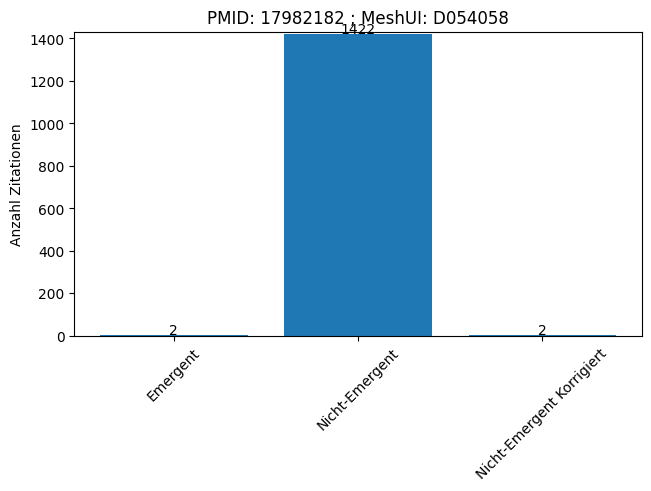

In [169]:
visualisiereENENEK(17982182, "D054058")